# Cost-sensitive learning


Cost-sensitive learning is a subfield of machine learning that addresses classification problems where the misclassification costs are not equal {cite}`fernandez2018learning,elkan2001foundations,ling2008cost`. Cost-sensitive problems occur in many disciplines such as medicine (e.g., disease detection), engineering (e.g., machine failure detection), transport (e.g., traffic-jam detection), finance (e.g., fraud detection), and so forth. They are often related to the class-imbalance problem since in most of these problems, the goal is to detect events that are rare. The training datasets therefore typically contain fewer examples of the event of interest.  

We already addressed fraud detection as a cost-sensitive problem in [Chapter 4, Cost Matrix](Performance_CostMatrix). The section pointed out the cost matrix as the standard way to quantify the misclassification costs. Denoting by $C$ the *cost matrix*, its entries $c(i,j)$ quantify the cost of predicting class $i$ when the true class is $j$ {cite}`elkan2001foundations`. For a binary classification problem, the cost matrix is a $2*2$ matrix, as illustrated in Fig. 1. 

![](images/cost_matrix1.png)
<div align="center">Fig. 1. Example of cost matrix.</div>    

Correct classifications have a cost of zero, that is, $c_{00}=c_{11}=0$. Misclassification costs are however in practice difficult to estimate. As discussed in [Chapter 4, Cost Matrix](Performance_CostMatrix), missing a fraudulent transaction (false negative) involves a loss directly related to the amount of the transaction, but also on further fraudulent uses of the card, and on the company reputation. At the same time, the blocking of transactions that are legitimate (false positive) causes inconvenience to customers, generates useless investigation costs, and also impacts the company reputation.  

In cost-sensitive imbalanced problems, the most popular heuristic approach to estimate the costs lies in utilizing the imbalance ratio (IR). Let us denote by $\mathcal{X}$ the imbalanced dataset, with $\mathcal{X}_0$ and $\mathcal{X}_1$ being the subsets of samples belonging to the majority and minority class, respectively. The IR of the dataset $\mathcal{X}$ is defined as {cite}`JMLR:v18:16-365`:

$$
IR=\frac{|\mathcal{X}_1|}{|\mathcal{X}_0|}
$$

where $|·|$ denotes the cardinality of a set. In this setting, $C(i,j) = IR$ and $C(j,i) = 1$, where the minority class is the i-th class, and the majority class is the j-th class. It is worth noting that using the IR as the cost for the majority class balances the overall cost of the two classes, that is, $|\mathcal{X}_1|=IR*|\mathcal{X}_0|$. The resulting cost matrix for a 2-class problem is given in Fig. 2.

![](images/cost_matrix_IR.png)
<div align="center">Fig. 2. Cost matrix for imbalanced data. The cost of a false negative is 1, and the cost of a false positive is the imbalance ratio (IR).</div>      

Using the IR to set the misclassification costs is usually a good heuristic. It however has some limitations, in particular related to small sample size, class overlapping, and noisy or borderline instances {cite}`fernandez2018learning`. A common complementary practice consists in considering the misclassification costs as a hyperparameter to be identified through model selection. 

Python sklearn provides support for cost-sensitive learning for most baseline classifiers thanks to the `class_weight` parameter. The parameter allows to specify costs in three different ways:

* `None`: The misclassification costs are set to 1 (default)
* `balanced`: The costs are set according to the imbalance ratio (as in Fig. 2)
* `{0:c10, 1:c01}`: The misclassification costs are explicitly set for the two classes by means of a dictionary.

The use of class weights usually implies a modification in the loss function of the learning algorithm. The modification depends on the type of algorithm. By strongly penalizing mistakes on the minority class, cost-sensitive learning improves their importance during the classifier training step. This pushes the decision boundary away from these instances, allowing to improve generalization on the minority class {cite}`fernandez2018learning,gupta2020class`.

This section presents how cost-sensitive learning can be used with the Python sklearn library. For better visualization, we first rely on a simple imbalanced dataset with two variables to illustrate how different misclassification costs change the decision boundaries. We then apply the approach to the larger simulated dataset of transaction data.  


In [42]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
%run shared_functions.py
#%run ../Chapter_References/shared_functions.ipynb

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed
        

## Illustrative example
For illustrative purposes, let us first consider a simple classification task. We use the `make_classification` function of the sklearn library to generate a two-class imbalanced dataset with 5000 examples. The dataset contains 95% of examples of class 0 and 5% of examples of class 1.  

In [2]:
X, y = sklearn.datasets.make_classification(n_samples=5000, n_features=2, n_informative=2,
                                            n_redundant=0, n_repeated=0, n_classes=2,
                                            n_clusters_per_class=1,
                                            weights=[0.95, 0.05],
                                            class_sep=0.5, random_state=0)

dataset_df = pd.DataFrame({'X1':X[:,0],'X2':X[:,1], 'Y':y})


The distribution of the two classes slighly overlap, as illustrated below.

In [3]:
%%capture
fig_distribution, ax = plt.subplots(1, 1, figsize=(5,5))

groups = dataset_df.groupby('Y')
for name, group in groups:
    ax.scatter(group.X1, group.X2, edgecolors='k', label=name,alpha=1,marker='o')
    
ax.legend(loc='upper left', 
          bbox_to_anchor=(1.05, 1),
          title="Class")

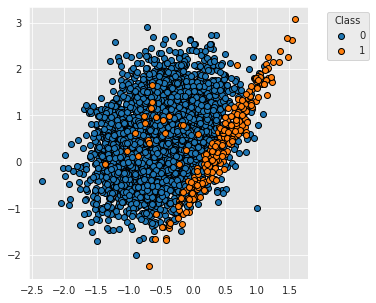

In [4]:
fig_distribution

### Decision tree
Let us now train a decision tree to separate the two classes. We use a decision tree of depth 5, and a stratified 5-fold cross-validation to assess the performances of the classifier. The performances are assessed in terms of AUC ROC, Average precision, and balanced accuracy. The class weights are set to 1 for both classes.

In [5]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight={0:1,1:1},random_state=0)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [6]:
cv_results_ = sklearn.model_selection.cross_validate(classifier, X, y, cv=cv,
                                                     scoring=['roc_auc',
                                                              'average_precision',
                                                              'balanced_accuracy'],
                                                     return_estimator=True)

The performances for each fold are returned in the `cv_results_` dictionary, which is better visualized as a DataFrame. 

In [7]:
results = round(pd.DataFrame(cv_results_),3)
results

,fit_time,score_time,estimator,test_roc_auc,test_average_precision,test_balanced_accuracy
0,0.005,0.002,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.933,0.616,0.842
1,0.006,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.871,0.493,0.739
2,0.005,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.897,0.493,0.799
3,0.004,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.928,0.591,0.812
4,0.005,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.901,0.447,0.738


Let us take the mean and standard deviation of the performances across all folds.

In [8]:
results_mean = list(results.mean().values)
results_std = list(results.std().values)

pd.DataFrame([[str(round(results_mean[i],3))+'+/-'+str(round(results_std[i],3)) for i in range(len(results))]],
            columns=['Fit time (s)','Score time (s)','AUC ROC','Average Precision','Balanced accuracy'])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
0,0.005+/-0.001,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046


The performances are rather good since the AUC ROC is well beyond $0.5$ and the average precision over $0.05$. The balanced accuracy is however not so high, suggesting that the decision boundary misclassifies many of the samples from the minority class. 

Let us finally plot the decision boundary provided by one of the decision trees. We use the decision tree obtained from the first fold of the cross-validation.

In [9]:
def plot_decision_boundary_classifier(ax, 
                                      classifier,
                                      train_df,
                                      input_features=['X1','X2'],
                                      output_feature='Y',
                                      title="",
                                      fs=14,
                                      plot_training_data=True):

    plot_colors = ["tab:blue","tab:orange"]

    x1_min, x1_max = train_df[input_features[0]].min() - 1, train_df[input_features[0]].max() + 1
    x2_min, x2_max = train_df[input_features[1]].min() - 1, train_df[input_features[1]].max() + 1
    
    plot_step=0.1
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
                         np.arange(x2_min, x2_max, plot_step))

    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu_r,alpha=0.3)

    if plot_training_data:
        # Plot the training points
        groups = train_df.groupby(output_feature)
        for name, group in groups:
            ax.scatter(group[input_features[0]], group[input_features[1]], edgecolors='black', label=name)
        
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel(input_features[0], fontsize=fs)
    ax.set_ylabel(input_features[1], fontsize=fs)
    

In [10]:
# Retrieve the decision tree from the first fold of the cross-validation
classifier_0 = cv_results_['estimator'][0]

In [11]:
# Retrieve the indices used for the training and testing of the first fold of the cross-validation
(train_index, test_index) = next(cv.split(X, y))

# Recreate the train and test DafaFrames from these indices
train_df = pd.DataFrame({'X1':X[train_index,0], 'X2':X[train_index,1], 'Y':y[train_index]})
test_df = pd.DataFrame({'X1':X[test_index,0], 'X2':X[test_index,1], 'Y':y[test_index]})
input_features = ['X1','X2']
output_feature = 'Y'

In [12]:
%%capture
fig_decision_boundary, ax = plt.subplots(1, 3, figsize=(5*3,5))

plot_decision_boundary_classifier(ax[0], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n With training data",
                                  plot_training_data=True)

plot_decision_boundary_classifier(ax[1], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n",
                                  plot_training_data=False)


plot_decision_boundary_classifier(ax[2], classifier_0,
                                  test_df,
                                  title="Decision surface of the decision tree\n With test data",
                                  plot_training_data=True)

ax[-1].legend(loc='upper left', 
              bbox_to_anchor=(1.05, 1),
              title="Class")

sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=0, vmax=1))
cax = fig_decision_boundary.add_axes([0.93, 0.15, 0.02, 0.5])
fig_decision_boundary.colorbar(sm, cax=cax, alpha=0.3, boundaries=np.linspace(0, 1, 11))

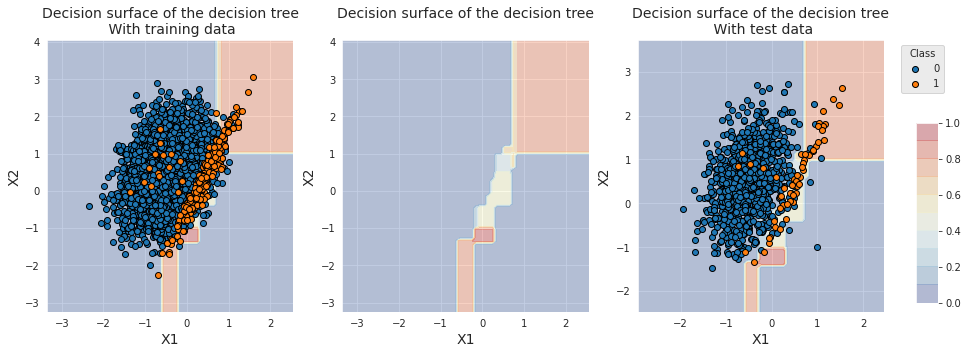

In [13]:
fig_decision_boundary

For better visualization, we report the decision boundaries alone (middle), with the training data (left), and with the test data (right). The plots show that the decision tree correctly identifies the region where the minority class samples lie. The decision tree however mostly classifies samples from the overlapping region into the majority class (yellow/blue color gradient).


We will reuse the functions above for computing the performances and for plotting the decision boundaries. For the sake of code conciseness, we implement two functions for computing the cross-validation results (`kfold_cv_with_classifier`) and for plotting the decision boundaries (`plot_decision_boundary`).

In [14]:
def kfold_cv_with_classifier(classifier,
                             X,
                             y,
                             n_splits=5,
                             strategy_name="Basline classifier"):
    
    cv = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    
    cv_results_ = sklearn.model_selection.cross_validate(classifier,X,y,cv=cv,
                                                         scoring=['roc_auc',
                                                                  'average_precision',
                                                                  'balanced_accuracy'],
                                                         return_estimator=True)
    
    results = round(pd.DataFrame(cv_results_),3)
    results_mean = list(results.mean().values)
    results_std = list(results.std().values)
    results_df = pd.DataFrame([[str(round(results_mean[i],3))+'+/-'+
                                str(round(results_std[i],3)) for i in range(len(results))]],
                              columns=['Fit time (s)','Score time (s)',
                                       'AUC ROC','Average Precision','Balanced accuracy'])
    results_df.rename(index={0:strategy_name}, inplace=True)
    
    classifier_0 = cv_results_['estimator'][0]
    
    (train_index, test_index) = next(cv.split(X, y))
    train_df = pd.DataFrame({'X1':X[train_index,0], 'X2':X[train_index,1], 'Y':y[train_index]})
    test_df = pd.DataFrame({'X1':X[test_index,0], 'X2':X[test_index,1], 'Y':y[test_index]})
    
    return (results_df, classifier_0, train_df, test_df)

In [15]:
def plot_decision_boundary(classifier_0,
                           train_df, 
                           test_df):
    
    fig_decision_boundary, ax = plt.subplots(1, 3, figsize=(5*3,5))

    plot_decision_boundary_classifier(ax[0], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n With training data",
                                  plot_training_data=True)

    plot_decision_boundary_classifier(ax[1], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n",
                                  plot_training_data=False)


    plot_decision_boundary_classifier(ax[2], classifier_0,
                                  test_df,
                                  title="Decision surface of the decision tree\n With test data",
                                  plot_training_data=True)

    ax[-1].legend(loc='upper left', 
                  bbox_to_anchor=(1.05, 1),
                  title="Class")

    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=0, vmax=1))
    cax = fig_decision_boundary.add_axes([0.93, 0.15, 0.02, 0.5])
    fig_decision_boundary.colorbar(sm, cax=cax, alpha=0.3, boundaries=np.linspace(0, 1, 11))
    
    return fig_decision_boundary

Let us recompute the performances and decision boundaries with these two functions.

In [16]:
%%capture
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight={0:1,1:1},random_state=0)


(results_df_dt_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                     X, y, 
                                                                                     n_splits=5,
                                                                                     strategy_name="Decision tree - Baseline")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


In [17]:
results_df_dt_baseline

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.005+/-0.0,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046


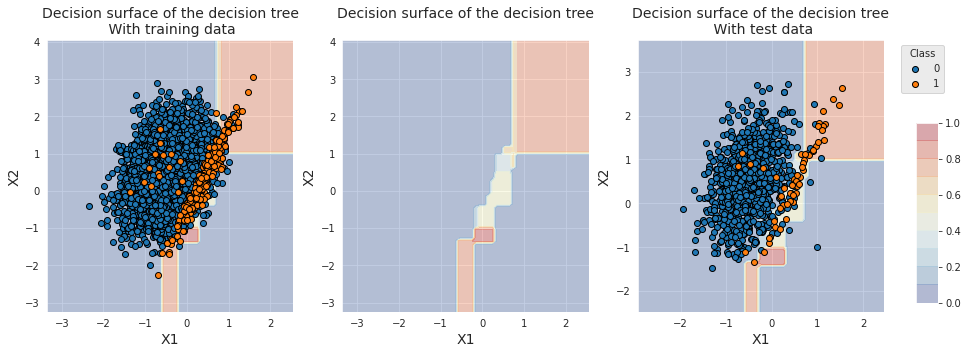

In [18]:
fig_decision_boundary

Let us now set the class weights so that false positives have a weight equal to the imbalance ratio.

In [19]:
IR=0.05/0.95

In [20]:
class_weight={0:IR,1:1}

In [21]:
%%capture
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight=class_weight,random_state=0)

(results_df_dt_cost_sensitive, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                         X, y, 
                                                                         n_splits=5,
                                                                         strategy_name="Decision tree - Cost-sensitive")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


In [22]:
pd.concat([results_df_dt_baseline, 
           results_df_dt_cost_sensitive])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.005+/-0.0,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - Cost-sensitive,0.005+/-0.001,0.001+/-0.001,0.887+/-0.034,0.471+/-0.059,0.898+/-0.021


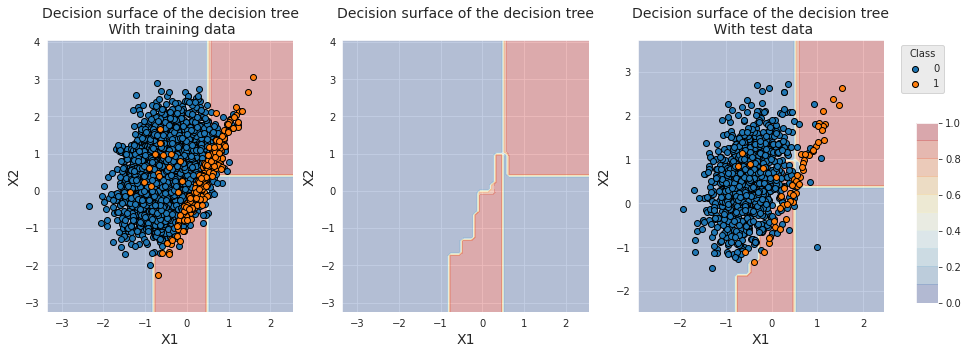

In [23]:
fig_decision_boundary

We observe that the decision boundary was shifted towards samples from the minority class. This shift allowed to increase the performance in terms of balanced accuracy, which increased from 0.786+/-0.046 to 0.898+/-0.021. We note however that the performances in terms of AUC ROC and Average Precision both decreased. 

### Logistic regression

Let us now apply the same methodology with a logistic regression classifier. We first build a classifier with equal weights for the two classes and run a stratified 5-fold cross-validation.

In [24]:
%%capture
classifier = sklearn.linear_model.LogisticRegression(C=1,class_weight={0:1,1:1},random_state=0)

(results_df_lr_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                          X, y, 
                                                                          n_splits=5,
                                                                          strategy_name="Logistic regression - Baseline")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


In [25]:
results_df_lr_baseline

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.004+/-0.001,0.001+/-0.001,0.937+/-0.012,0.535+/-0.065,0.641+/-0.048


The performances in terms of AUC ROC and Average Precision are higher than with a decision tree, but lower in terms of balanced accuracy. 

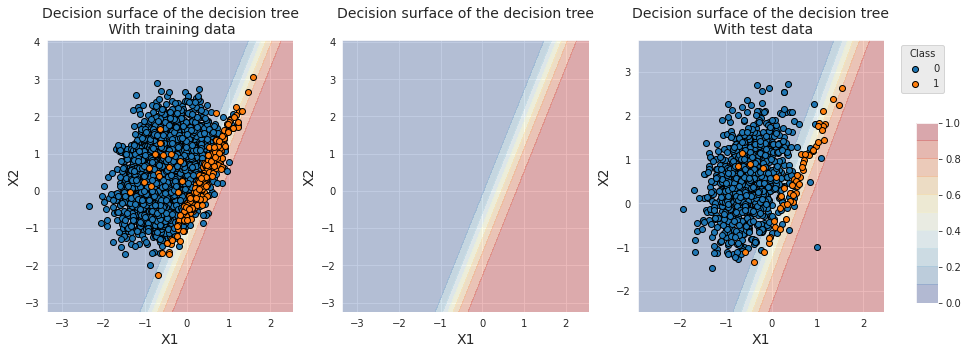

In [26]:
fig_decision_boundary

The decision boundary illustrates the linear separation that results from logistic regression. Due to the class imbalance, we observe that the decision boundary slightly favors the majority class. 

As for the decision tree, let us change the class weights, using the imbalance ratio as the weight for the majority class. 

In [27]:
%%capture
classifier = sklearn.linear_model.LogisticRegression(C=1,class_weight={0:IR,1:1},random_state=0)

(results_df_lr_cost_sensitive, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                         X, y, 
                                                                         n_splits=5,
                                                                         strategy_name="Logistic regression - Cost-sensitive")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)


In [28]:
pd.concat([results_df_lr_baseline, results_df_lr_cost_sensitive])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.004+/-0.001,0.001+/-0.001,0.937+/-0.012,0.535+/-0.065,0.641+/-0.048
Logistic regression - Cost-sensitive,0.003+/-0.0,0.001+/-0.001,0.937+/-0.012,0.536+/-0.064,0.899+/-0.01


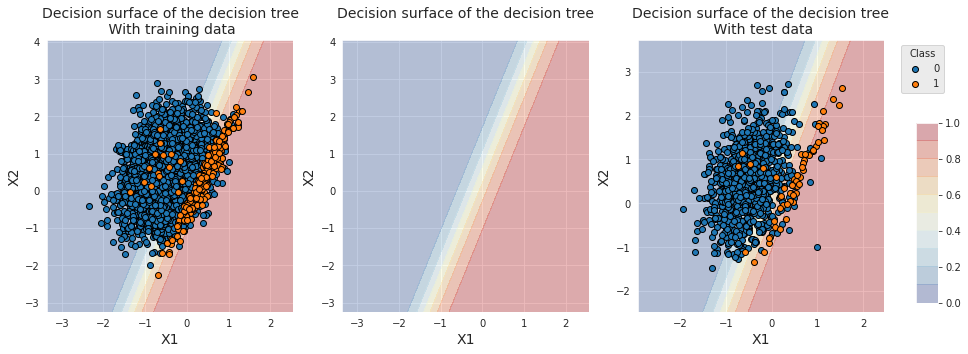

In [29]:
fig_decision_boundary

We observe that the decision boundary moved to the left, favoring the classification of the minority class. We note a strong increase of the balanced accuracy, from 0.641+/-0.048 to 0.899+/-0.01. The AUC ROC and Average Precision remain as good as the classifier with equal weights. 

The examples above show that tuning the class weights can improve classification performances. It is however worth noting that the performance improvements depend on the performance metric. For both classifiers, reducing the class weight of the majority class allowed to increase the balanced accuracy. The accuracy in terms of AUC ROC and Average Precision however remained unchanged for logistic regression and decreased for decision trees. 

In [30]:
results_df = pd.concat([results_df_dt_baseline,
                        results_df_dt_cost_sensitive,
                        results_df_lr_baseline,
                        results_df_lr_cost_sensitive])
results_df

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.005+/-0.0,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046
Decision tree - Cost-sensitive,0.005+/-0.001,0.001+/-0.001,0.887+/-0.034,0.471+/-0.059,0.898+/-0.021
Logistic regression - Baseline,0.004+/-0.001,0.001+/-0.001,0.937+/-0.012,0.535+/-0.065,0.641+/-0.048
Logistic regression - Cost-sensitive,0.003+/-0.0,0.001+/-0.001,0.937+/-0.012,0.536+/-0.064,0.899+/-0.01


## Transaction data

Let us now explore whether changing the class weights can improve the classification performances on the simulated dataset of transaction data. We reuse the methodology of [Chapter 5, Model Selection](Model_Selection), using prequential validation as the validation strategy. 


### Load data

The loading of data and initialization of the parameters follow the same template as in [Chapter 5, Model Selection](Model_Selection).

In [31]:
# Load data from the 2018-07-11 to the 2018-09-14

DIR_INPUT = 'simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


# Number of folds for the prequential validation
n_folds = 4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }


Load  files
CPU times: user 139 ms, sys: 173 ms, total: 312 ms
Wall time: 313 ms
919767 transactions loaded, containing 8195 fraudulent transactions


### Decision tree

The transaction dataset contains around 0.7% of fraudulent transactions. The imbalance ratio is therefore around 1/100. In order to assess the impact of the class weight parameter on the classification performance, we vary the class weight in the range 0.01 to 1, with the following set of possible values: $[0.01, 0.05, 0.1, 0.5, 1]$. 

The implementation is the same as in [Chapter 5](Model_Selection_Decision_Tree). The only modification consists in varying the class weight parameter (`clf__class_weight`) instead of the decision tree depth. We use a decision tree depth of 5 (`clf__max_depth`). 


In [32]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'clf__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1]]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          start_date_training_for_test,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_dt = time.time()-start_time



Let us use the class weight as the varying parameter, and summarize the performances as a function of the class weight.

In [33]:
# Select parameter of interest (class_weight)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__class_weight'][0] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt = performances_df


In [34]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.825500,0.009464,0.537440,0.033668,0.289286,0.010903,"{'clf__class_weight': {0: 0.01}, 'clf__max_dep...",0.328339,0.837454,0.014356,0.532924,0.025252,0.277500,0.010944,0.01
1,0.792912,0.029734,0.561153,0.046031,0.273571,0.019418,"{'clf__class_weight': {0: 0.05}, 'clf__max_dep...",0.332357,0.808213,0.022140,0.565880,0.027737,0.266071,0.013716,0.05
2,0.784486,0.031698,0.556320,0.031025,0.272143,0.019548,"{'clf__class_weight': {0: 0.1}, 'clf__max_dept...",0.330939,0.814153,0.023492,0.572758,0.029783,0.269643,0.015791,0.10
3,0.798043,0.020988,0.579394,0.016007,0.278214,0.003093,"{'clf__class_weight': {0: 0.5}, 'clf__max_dept...",0.255227,0.799682,0.013524,0.568408,0.018631,0.265000,0.013420,0.50
4,0.810138,0.008586,0.600306,0.016797,0.284286,0.004286,"{'clf__class_weight': {0: 1}, 'clf__max_depth'...",0.259228,0.804218,0.016505,0.546094,0.042197,0.267857,0.013869,1.00


In [35]:
summary_performances_dt = get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.01,0.1,0.01
Validation performance,0.837+/-0.01,0.573+/-0.03,0.278+/-0.01
Test performance,0.825+/-0.01,0.556+/-0.03,0.289+/-0.01
Optimal parameter(s),0.01,1.0,0.01
Optimal test performance,0.825+/-0.01,0.6+/-0.02,0.289+/-0.01


We observe that the optimal class weight for the majority class depends on the performance metric. For better visualization, let us plot the performances as a function of the class weight for the three performance metrics. 

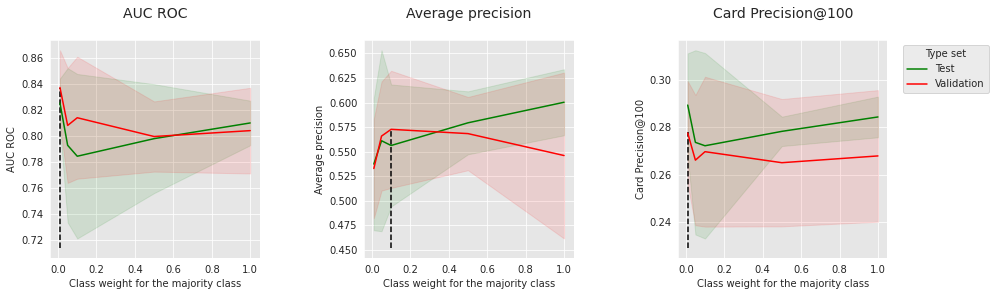

In [36]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Class weight for the majority class",
                       summary_performances=summary_performances_dt)

The results are mitigated, showing conflicting trends between the class weight of the majority class and the performance gains. For AUC ROC and CP@100, a class weight close to the imbalance ratio (0.01) provides the highest performance for both the test set and validation set, but the lowest performance in terms of Average Precision. 

### Logistic regression

Let us follow the same methodology as above, using logistic regression as the classification algorithm.

In [37]:
# Define classifier
classifier = sklearn.linear_model.LogisticRegression()

# Set of parameters for which to assess model performances
parameters = {'clf__C':[1], 'clf__random_state':[0],
              'clf__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1]]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          start_date_training_for_test,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_lr = time.time()-start_time



In [38]:
# Select parameter of interest (class_weight)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__class_weight'][0] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_lr=performances_df


In [39]:
performances_df_lr

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.871396,0.017137,0.571129,0.028027,0.293929,0.010120,"{'clf__C': 1, 'clf__class_weight': {0: 0.01}, ...",0.171703,0.871069,0.009955,0.497808,0.039734,0.276429,0.013190,0.01
1,0.870711,0.016332,0.604805,0.015834,0.296786,0.009813,"{'clf__C': 1, 'clf__class_weight': {0: 0.05}, ...",0.190675,0.870584,0.008772,0.550617,0.029466,0.278571,0.015085,0.05
2,0.870083,0.016028,0.613923,0.014765,0.296429,0.008950,"{'clf__C': 1, 'clf__class_weight': {0: 0.1}, '...",0.193464,0.869906,0.008720,0.579392,0.019886,0.278214,0.014156,0.10
3,0.868234,0.015572,0.621852,0.015687,0.297500,0.008770,"{'clf__C': 1, 'clf__class_weight': {0: 0.5}, '...",0.211798,0.867853,0.008948,0.608950,0.023132,0.277143,0.015286,0.50
4,0.867643,0.015404,0.623081,0.016204,0.297143,0.008806,"{'clf__C': 1, 'clf__class_weight': {0: 1}, 'cl...",0.220923,0.866861,0.008988,0.612264,0.023474,0.278214,0.016914,1.00


In [40]:
summary_performances_lr = get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.01,1.0,0.05
Validation performance,0.871+/-0.01,0.612+/-0.02,0.279+/-0.02
Test performance,0.871+/-0.02,0.623+/-0.02,0.297+/-0.01
Optimal parameter(s),0.01,1.0,0.5
Optimal test performance,0.871+/-0.02,0.623+/-0.02,0.298+/-0.01


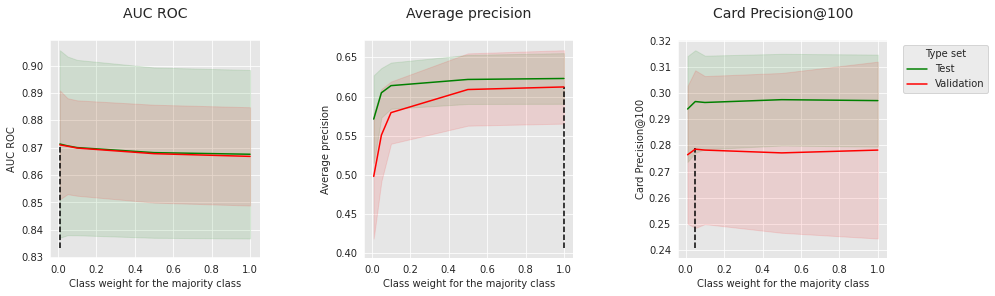

In [41]:
get_performances_plots(performances_df_lr, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Class weight for the majority class",
                       summary_performances=summary_performances_lr)

Similar to decision trees, the results are mitigated. Slightly higher performances are obtained for AUC ROC with a low class weight for the majority class. The performances in terms Average Precision and CP@100 however follow the opposite trend. 

## Summary

The benefits of relying on misclassification costs in the training procedure therefore appear to be strongly dependent on the characteristics of a dataset and on the performance metric to optimize. The experiments provided in this section showed that cost-sensitive learning effectively allows to shift the decision boundary of a classifier and to favor the classification of the minority class. Its benefits in terms of AUC ROC and Average Precision seem however conflicting. In particular, the shift of the decision boundary seems to lead to many false positives, that negatively impact the precision, and therefore, the performance in terms of Average Precision.   


## Saving of results

Let us finally save the performance results and execution times.

In [42]:
performances_df_dictionary = {
    "Decision Tree": performances_df_dt,
    "Logistic Regression": performances_df_lr
}

execution_times = [execution_time_dt,
                   execution_time_lr
                  ]


Both data structures are saved as a Pickle file.

In [ ]:
filehandler = open('performances_cost_sensitive.pkl', 'wb') 
pickle.dump((performances_df_dictionary, execution_times), filehandler)
filehandler.close()